# Import and Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sklearn
import tqdm
import random

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [3]:
SEED = 42
def seed_all(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)

seed_all()

In [4]:
df = pd.read_csv('drive/MyDrive/CS671_project/data/diabetes_binary_health_indicators_BRFSS2015.csv')

# EDA & Preprocessing

In [5]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Dependent variable

In [6]:
y = df['Diabetes_binary'].astype(int)
y.value_counts(normalize=True)

,proportion
Diabetes_binary,
0,0.860667
1,0.139333


The dataset is imbalanced, with only ~14% of positive class subjects (i.e., those with diabetes). Subsampling or data augmentation will need to be performed to solve the issue.

## Independent variables

There are 21 dependent variables, listed below by their types:
- Continuous: `BMI`, `MenHlth`, `PhysHlth`
- Ordinal: `GenHlth`, `Age`, `Education`, `Income`
- Categorical: `HighBP`, `HighChol`, `CholCheck`, `Smoker`, `Stroke`, `HeartDiseaseorAttack`, `PhysActivity`, `Fruits`, `Veggies`, `HvyAlcoholConsump`, `AnyHealthcare`, `NoDocbcCost`, `DiffWalk`, `Sex`. All categorical variables invovled are binary.

In [7]:
X = df.iloc[:,1:]
X.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In order to solve the data imbalance issue, we subsample the negative samples such that there are exactly 50% of positive and 50% negative samples in the used dataset.

In [8]:
subsample_idx = X[y==0].sample(n=y.sum(), random_state=SEED).index
X = pd.concat([X[y==1], X.loc[subsample_idx,:]])
y = pd.concat([y[y==1], y.loc[subsample_idx]])

In [9]:
var_num = ['BMI', 'MentHlth', 'PhysHlth']
var_ord = ['GenHlth', 'Age', 'Education', 'Income']
var_cat = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'
]

for var in var_cat:
  X[var] = X[var].astype(int)

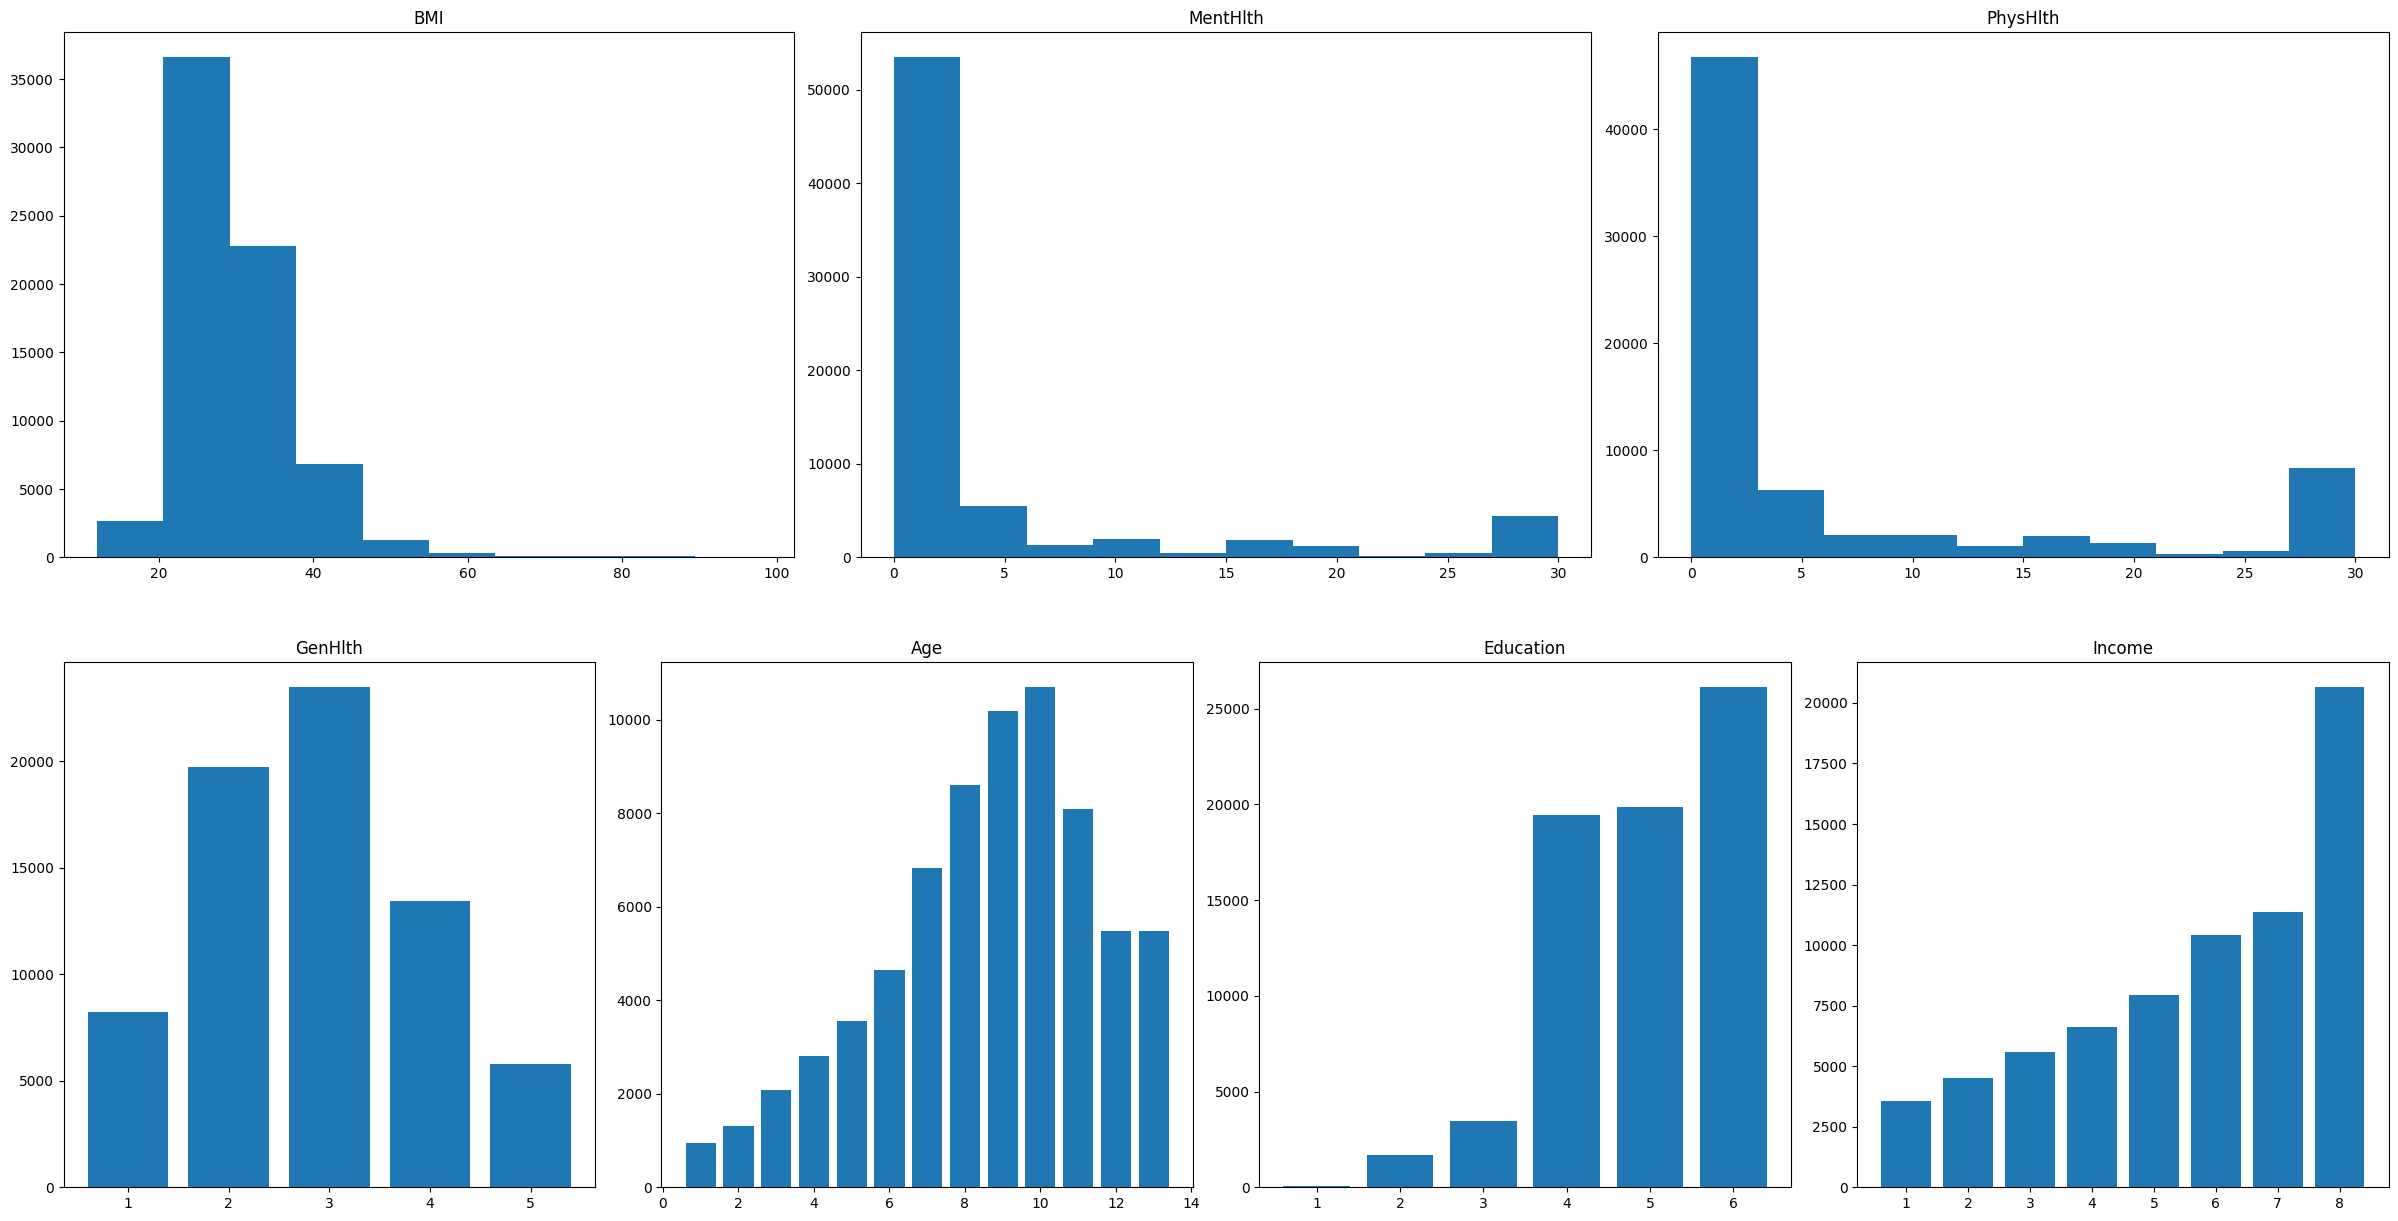

In [10]:
nrow, ncol = 2, 3
fig = plt.figure(figsize=(30, 15))
gs = GridSpec(2, 12, figure=fig)

ax_num = []
for i in range(3):
  ax_num.append(fig.add_subplot(gs[0, (4*i):(4*i+4)]))
ax_ord = []
for i in range(4):
  ax_ord.append(fig.add_subplot(gs[1, (3*i):(3*i+3)]))

plt.subplots_adjust(wspace=0.5)

for ax, var in zip(ax_num, var_num):
  ax.hist(X[var])
  ax.set_title(var)
for ax, var in zip(ax_ord, var_ord):
  counts = X[var].astype(int).value_counts().sort_index()
  ax.bar(counts.index.to_numpy(), counts.to_numpy())
  ax.set_title(var)

fig.show()

## EDA through ROC

We explore the predictive power of each feature using ROC.

Observations:
- One line (`GenHlth`) almost always outperforms any other feature, indicating its role as a potential significant predictor.
- Plenty of variables are no better than random guess, indicating the necessity of more complex models / correlation between variables.

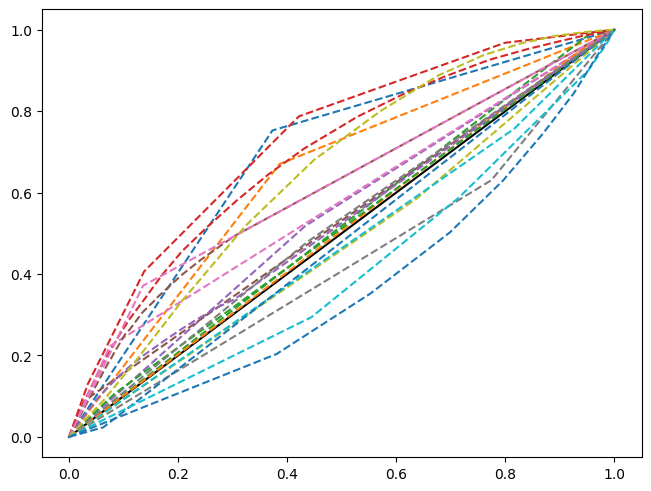

In [11]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.linspace(0,1,2), np.linspace(0,1,2), color='k')
for col in X.columns:
    fpr, tpr, thres = roc_curve(y, X[col])
    # auc = roc_auc_score(y, X[col])
    # if auc < 0.5: # below line
    #   fpr, tpr, thres = roc_curve(y, -X[col])
    # else:
    #   fpr, tpr, thres = roc_curve(y, X[col])
    ax.plot(fpr, tpr, '--')


# Variable Importance

## Data Preparation

We split the data set to let 90% of data be the training and validation set and the rest 10% be the testing set. We also stratify in the sampling process so that the positive and negative subjects within each set is roughly 50-50.

In [12]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED, stratify=y)

In [13]:
# Pipeline
def compute_fi(modelclass, parameters, scoring='recall'):
    # Model pipeline: Preprocessing (scaling by robust statistics) + classifier
    scaler = RobustScaler().fit(X_train_val)
    clf = modelclass()
    ppl = Pipeline([('scaler', scaler), ('clf', clf)])

    # CV
    clf_cv = GridSearchCV(ppl, parameters, scoring=scoring, refit=scoring)
    clf_cv.fit(X_train_val, y_train_val)
    cv_results = clf_cv.cv_results_
    print(f"Best params: {clf_cv.best_params_}")

    # Fit best model
    ppl = clf_cv.best_estimator_
    ppl.fit(X_train_val, y_train_val)
    y_pred = ppl.predict(X_test)
    y_pred_prob = ppl.predict_proba(X_test)
    print(f"Test precision score: {precision_score(y_test, y_pred)}")
    print(f"Test recall score: {recall_score(y_test, y_pred)}")
    print(f"Test f1 score: {f1_score(y_test, y_pred)}")
    print(f"Test accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"Test ROC AUC score: {roc_auc_score(y_test, y_pred_prob[:,1])}")

    # Confusion matrix of best model
    cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    cm.plot()
    plt.title("Confusion matrix")
    plt.show()

    # Compute permutation feature importance
    perm_fi = permutation_importance(
        ppl, X, y, scoring=scoring, n_repeats=10, random_state=42, n_jobs=2
    )
    print(f"Permutation FI: {perm_fi['importances_mean']}")
    fig, ax = plt.subplots()
    pd.Series(perm_fi['importances_mean'], index=X.columns).plot.bar(yerr=perm_fi['importances_std'], ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel(f"Mean decrease in {scoring} score")
    fig.tight_layout()
    return cv_results, ppl

## Baseline: Random Guess

In [14]:
random_guess = np.full((10, 4), 0.)
for i in range(10):
    y_shuffled = np.random.permutation(y.to_numpy().copy())
    random_guess[i, 0] = precision_score(y, y_shuffled)
    random_guess[i, 1] = recall_score(y, y_shuffled)
    random_guess[i, 2] = f1_score(y, y_shuffled)
    random_guess[i, 3] = accuracy_score(y, y_shuffled)

rg_mean = np.mean(random_guess, axis=0)

for i, scoring in enumerate(('precision', 'recall', 'f1', 'accuracy')):
    print('Mean {} score: {}'.format(scoring, rg_mean[i]))

Mean precision score: 0.501063769592033
Mean recall score: 0.501063769592033
Mean f1 score: 0.501063769592033
Mean accuracy score: 0.501063769592033


## (a) Logistic Regression


Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Test precision score: 0.7323450134770889
Test recall score: 0.7685997171145686
Test f1 score: 0.7500345065562457
Test accuracy score: 0.7438472418670439
Test ROC AUC score: 0.8216428161304714


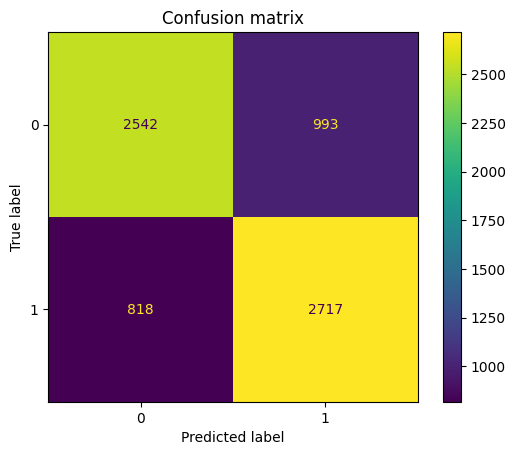

Permutation FI: [ 3.39076557e-02  1.55746053e-02  6.23550048e-03  3.48497708e-02
  3.96084423e-05 -5.40372319e-04 -1.49380411e-03 -3.84767725e-04
 -8.03485543e-04 -1.41458722e-04  3.18847960e-03 -8.77044079e-05
  0.00000000e+00  6.45815651e-02  8.43093985e-04  2.71317829e-03
 -2.04266395e-03  3.12906694e-03  4.23244497e-02 -7.75193798e-04
 -9.64748486e-04]


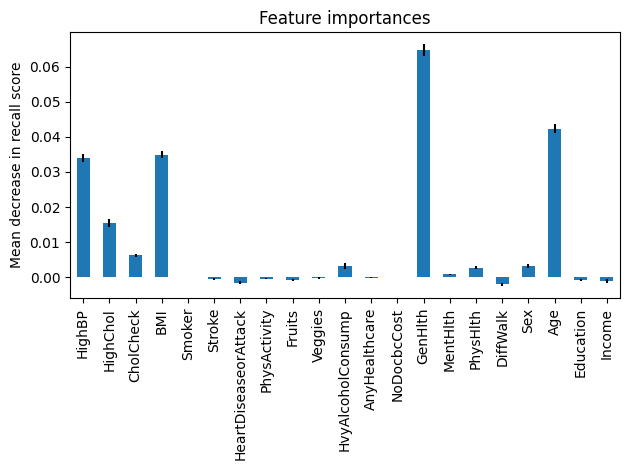

In [15]:
parameters = {
    "clf__penalty": ('None', 'l1', 'l2'),
    "clf__C": np.logspace(-5, 1, 7),
    "clf__solver": ('lbfgs', 'liblinear')
}
_ = compute_fi(LogisticRegression, parameters)

## (b) Decision Tree

Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__max_features': 21}
Test precision score: 0.6703703703703704
Test recall score: 0.8192362093352192
Test f1 score: 0.7373647358370464
Test accuracy score: 0.7082036775106082
Test ROC AUC score: 0.7725901622289931


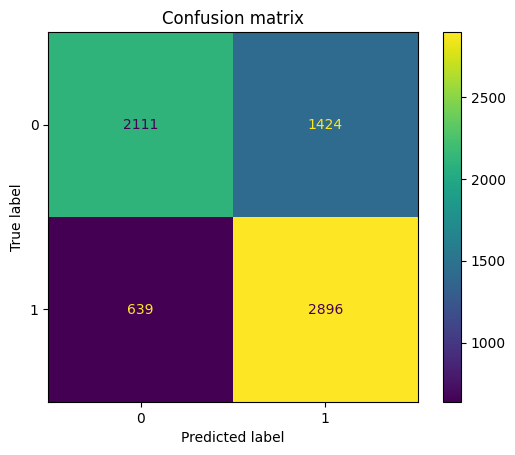

Permutation FI: [0.02044079 0.         0.         0.01172693 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.06739376 0.         0.         0.         0.
 0.00231992 0.         0.        ]


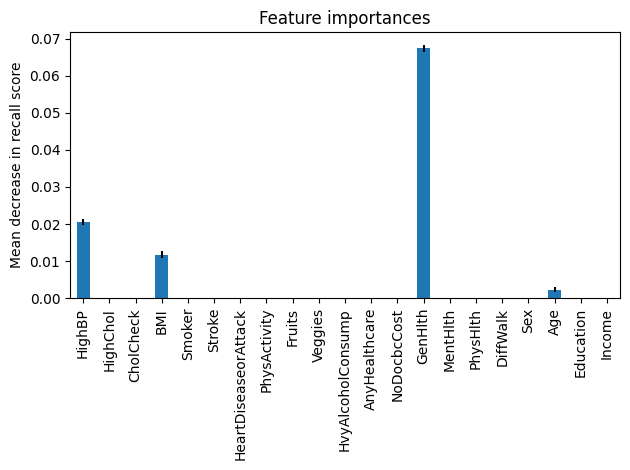

In [16]:
parameters = {
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_depth": (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    "clf__max_features": (21, 10, 5, 3)
}
cv_results_final, ppl_final = compute_fi(DecisionTreeClassifier, parameters)

## (c) Random Forest

Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5}
Test precision score: 0.7236220472440945
Test recall score: 0.7799151343705799
Test f1 score: 0.7507147719537101
Test accuracy score: 0.7410183875530411
Test ROC AUC score: 0.8161682027972448


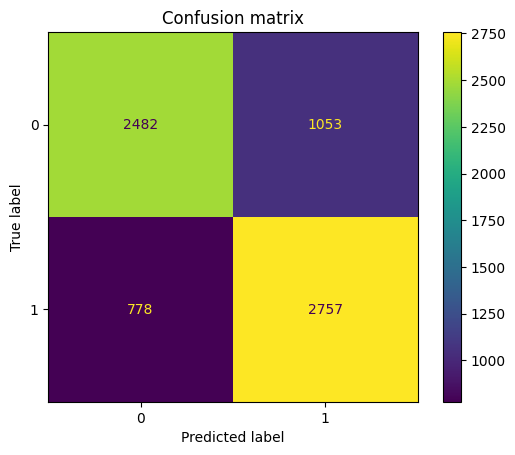

Permutation FI: [ 3.15849035e-02  8.94584960e-03  1.05245289e-03  1.65789623e-02
 -2.54625700e-05 -1.66921292e-04 -1.75691733e-03 -5.00763877e-04
 -1.24483676e-04 -3.96084423e-05  9.95869405e-04 -4.24376167e-05
 -7.63877101e-05  3.72489108e-02  1.27312850e-04 -3.55344311e-03
 -9.24574209e-03  1.01850280e-04  1.44938607e-02 -7.92168845e-05
 -4.32863690e-04]


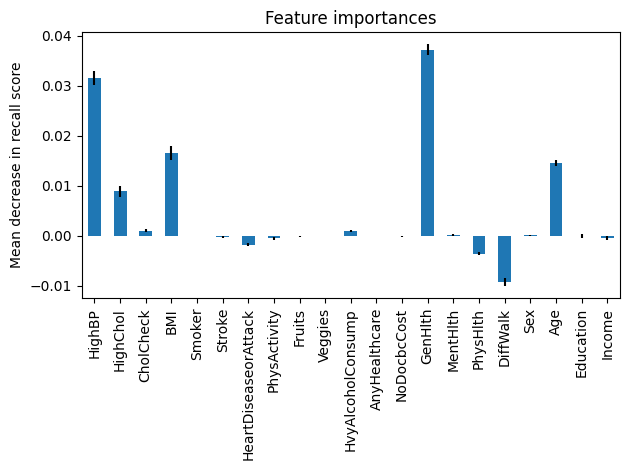

In [17]:
parameters = {
    "clf__criterion": ('gini', 'entropy', 'log_loss'),
    "clf__max_depth": (1, 2, 3, 4, 5)
}
_ = compute_fi(RandomForestClassifier, parameters)

## (d) Gradient Boosting

Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__subsample': 1.0}
Test precision score: 0.7301668806161746
Test recall score: 0.8045261669024045
Test f1 score: 0.7655450874831763
Test accuracy score: 0.7536067892503536
Test ROC AUC score: 0.8292569556005913


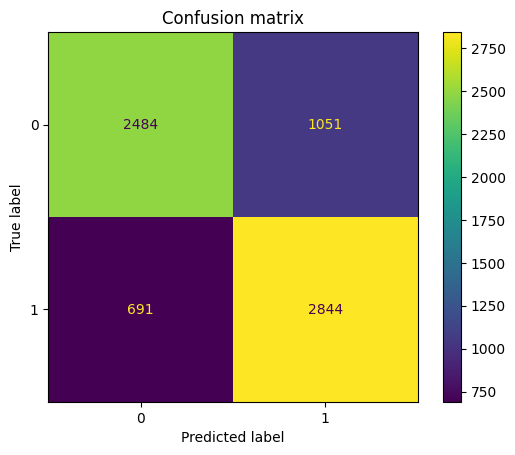

Permutation FI: [ 2.24070616e-02  1.14977650e-02  6.78718950e-03  4.08023539e-02
 -6.13930855e-04 -1.17127822e-03 -1.50512081e-03 -7.49731228e-04
 -2.94234142e-04 -1.49946246e-04  6.61743903e-03  2.54625700e-05
 -3.50817631e-04  3.48808918e-02  3.38369264e-03  4.13059469e-04
 -2.67074068e-03  5.50557347e-03  3.76506535e-02 -2.88575794e-04
  1.38629548e-04]


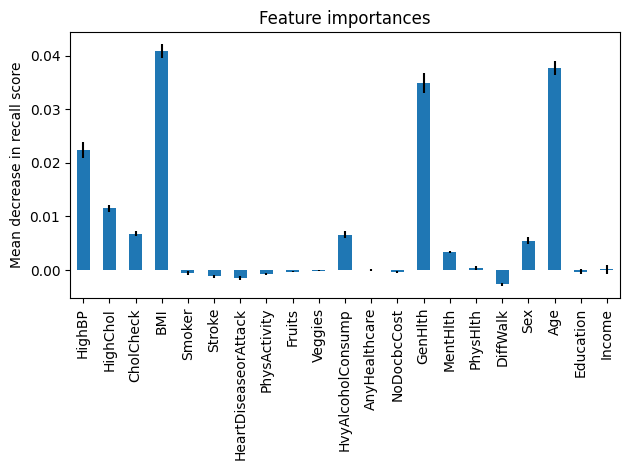

In [18]:
parameters = {
    "clf__learning_rate": (0.01, 0.1, 1.0),
    "clf__subsample": (0.1, 0.2, 0.5, 1.0),
    "clf__max_depth": (1, 2, 3, 4, 5)
}
_ = compute_fi(GradientBoostingClassifier, parameters)

## (e) AdaBoost

Best params: {'clf__algorithm': 'SAMME', 'clf__learning_rate': 0.1}
Test precision score: 0.7128456965624193
Test recall score: 0.7801980198019802
Test f1 score: 0.7450027012425716
Test accuracy score: 0.732956152758133
Test ROC AUC score: 0.8049190455517568


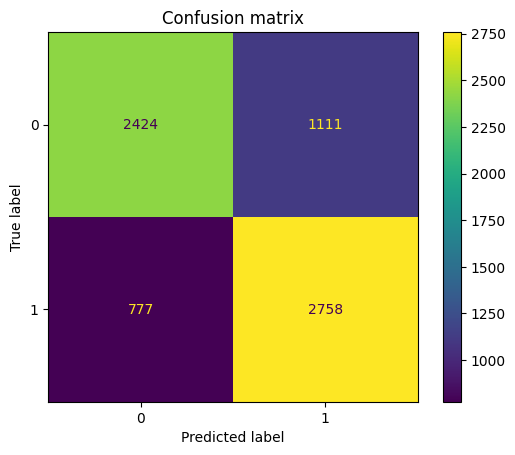

Permutation FI: [ 0.03563628  0.0076614   0.          0.01903469  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.06938267  0.          0.         -0.00163809  0.
  0.01283879  0.          0.        ]


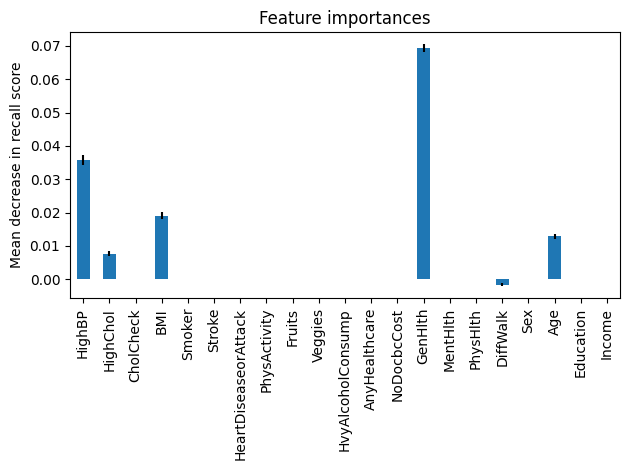

In [19]:
parameters = {
    "clf__learning_rate": (0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0),
    "clf__algorithm": ('SAMME',)
}
_ = compute_fi(AdaBoostClassifier, parameters)

## (f) XGBoost

Best params: {'clf__grow_policy': 'depthwise', 'clf__learning_rate': 0.1, 'clf__max_depth': 5}
Test precision score: 0.7294117647058823
Test recall score: 0.8067892503536068
Test f1 score: 0.7661517797179315
Test accuracy score: 0.7537482319660538
Test ROC AUC score: 0.8289694287674878


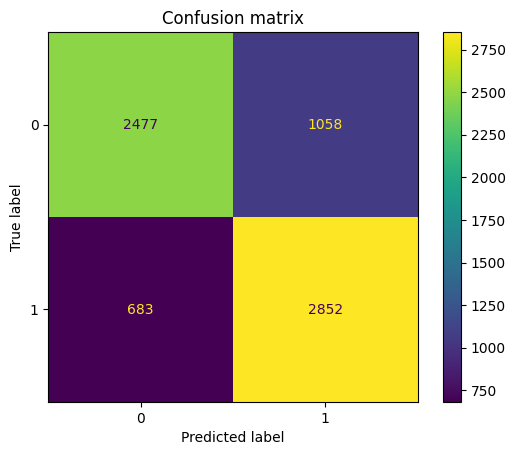

Permutation FI: [ 2.40706162e-02  1.28501103e-02  6.25530470e-03  4.12521926e-02
 -9.33627567e-05 -1.10903638e-03 -1.53624172e-03 -2.37650654e-04
 -1.86725513e-04 -3.45159283e-04  6.47598031e-03  1.18825327e-04
  7.35585356e-05  3.68471680e-02  4.06269451e-03  1.09489051e-03
 -2.59152379e-03  6.41090930e-03  3.78204040e-02  8.03485543e-04
  1.13166978e-03]


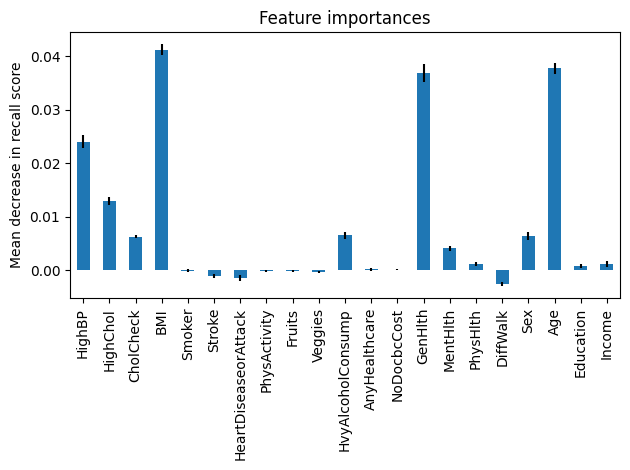

In [20]:
parameters = {
    "clf__max_depth": (1, 2, 3, 4, 5),
    "clf__learning_rate": (0.1, 1.0, 10.0),
    "clf__grow_policy": ('depthwise', 'lossguide')
}
_ = compute_fi(XGBClassifier, parameters)

# Results

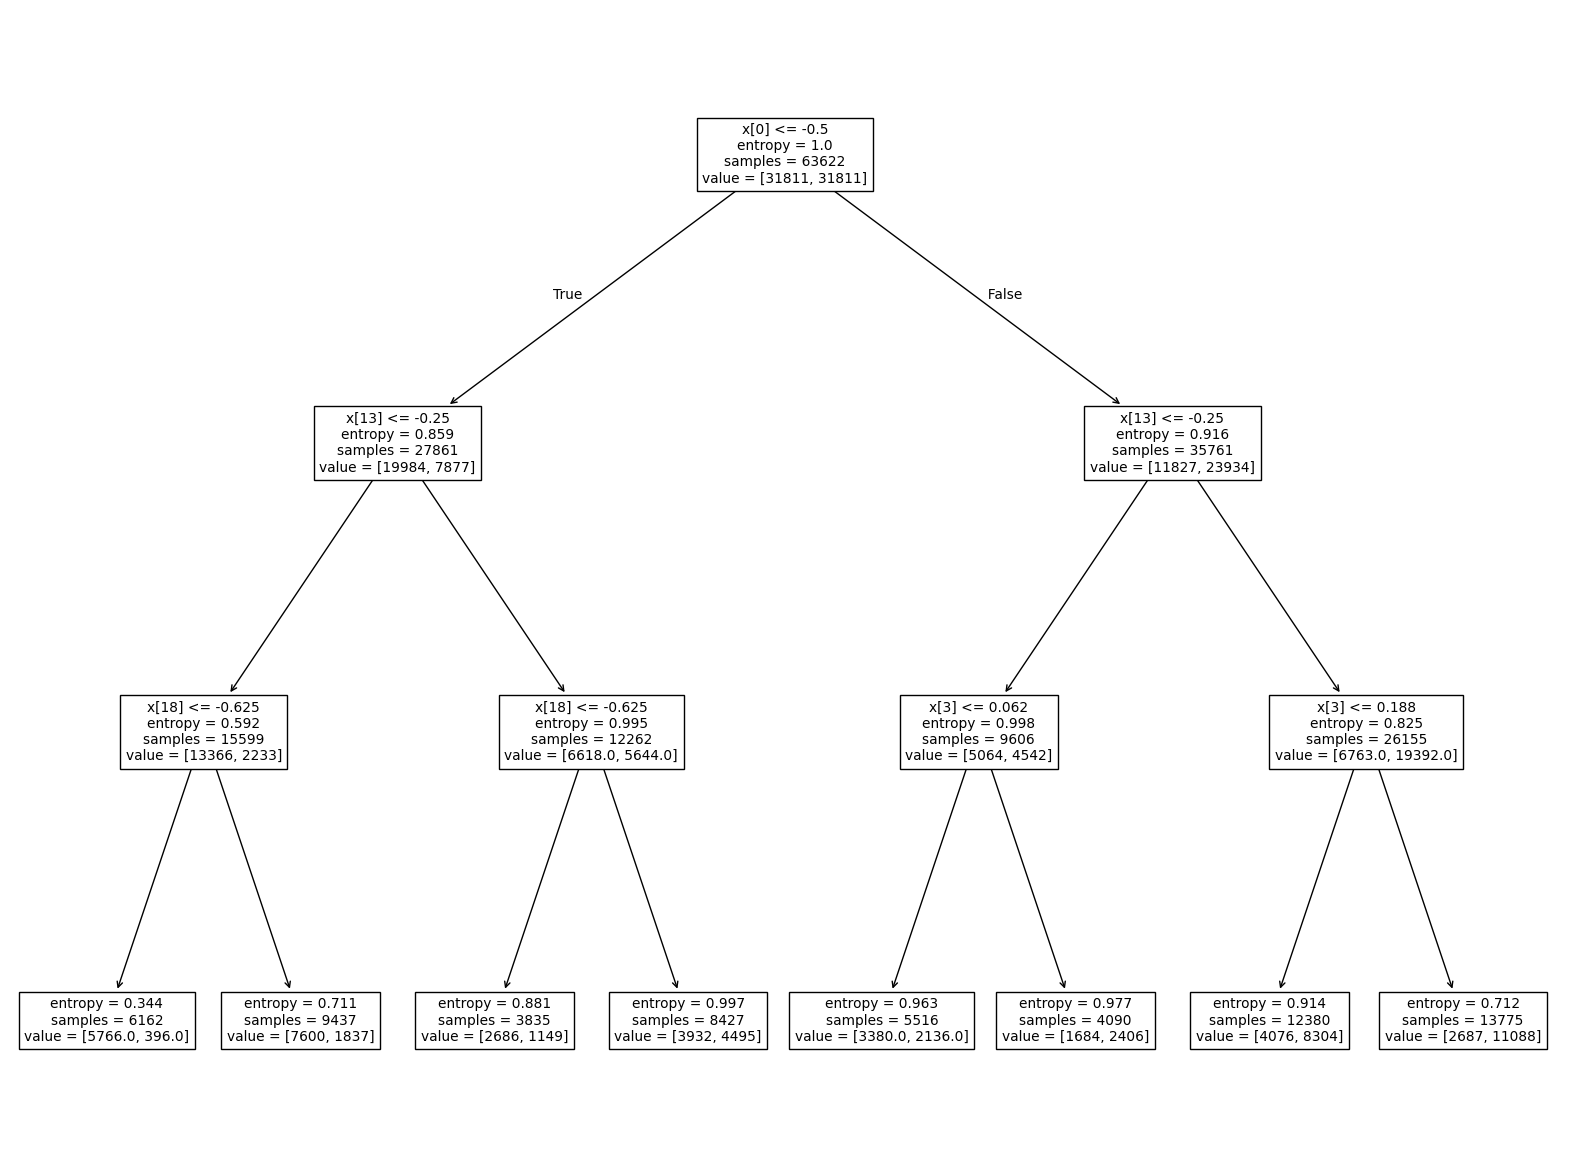

In [23]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(20,15))
_ = plot_tree(ppl_final.named_steps['clf'])

In [24]:
X.columns[0], X.columns[13], X.columns[18], X.columns[3]

('HighBP', 'GenHlth', 'Age', 'BMI')

Comparing across the six permutation FI graphs, we find that all models suggest that **Genetal Health**, **BMI**, **Age**, **High Blood Pressure**, and **High Cholestrol** are important variables to predicting diabetes. The consistency implies that their importance regardless of the class of model we choose.


## Hyperparameter Tuning

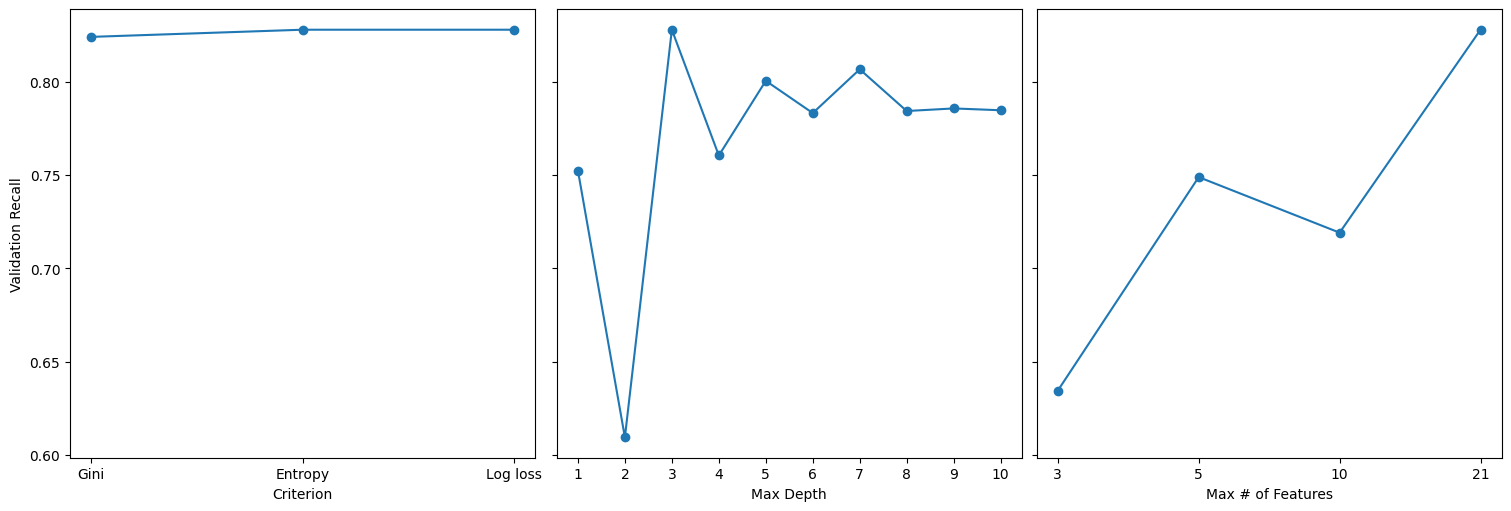

In [43]:
# criterion: 8, 48, 88
# depth: 40, 44, 48, 52, 56, 60, 64, 68, 72, 76
# features: 48, 49, 50, 51

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5), layout='constrained')
ax1.plot(np.arange(3), cv_results_final['mean_test_score'][[8, 48, 88]], 'o-')
ax1.set_xticks(np.arange(3))
ax1.set_xticklabels(['Gini', 'Entropy', 'Log loss'])
ax1.set_xlabel('Criterion')
ax1.set_ylabel('Validation Recall')
ax2.plot(np.arange(10) + 1, cv_results_final['mean_test_score'][[40, 44, 48, 52, 56, 60, 64, 68, 72, 76]], 'o-')
ax2.set_xticks(np.arange(10) + 1)
ax2.set_xlabel('Max Depth')
ax3.plot(np.arange(4), cv_results_final['mean_test_score'][[51, 50, 49, 48]], 'o-')
ax3.set_xticks(np.arange(4))
ax3.set_xticklabels([3, 5, 10, 21])
ax3.set_xlabel('Max # of Features')
plt.show()